# UMAP with Full ZScored & Clinical Metadata

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")


df = pd.read_csv(os.getenv("MEDIAN_CENTERED"),index_col=0)

zscored_df = pd.read_csv(os.getenv("ZSCORED"),index_col=0)

clinical_df = pd.read_csv(os.getenv("CLINICAL"),index_col=0)

# Set title as index
#clinical_df_indexed = clinical_df.set_index("title")
clinical_df_indexed = clinical_df.copy()

# Align both
common_samples = df.index.intersection(clinical_df_indexed.index)
expression_df = df.loc[common_samples]
clinical_df_indexed = clinical_df_indexed.loc[common_samples]


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


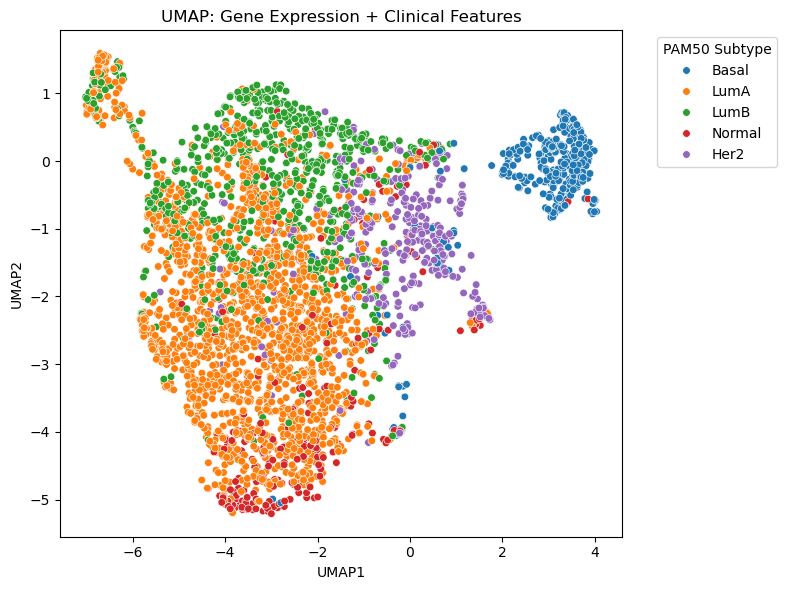

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 0: Select and clean clinical features ---
id_columns = [
    'last_update_date__Mar 12 2018',
    'last_update_date__May 04 2022',
    'instrument model__HiSeq 2000',
    'instrument model__NextSeq 500',
    "er prediction mgc", "pgr prediction mgc", "her2 prediction mgc", "ki67 prediction mgc",
    "nhg prediction mgc", "er prediction sgc", "pgr prediction sgc", "her2 prediction sgc", "ki67 prediction sgc"
]

# Keep numeric clinical columns only
clinical_features = clinical_df_indexed.select_dtypes(include=[np.number]).drop(columns=[col for col in id_columns if col in clinical_df_indexed.columns])

# Align sample indices
clinical_features = clinical_features.loc[zscored_df.index]

# --- Step 1: Separate column types ---
onehot_cols = [col for col in clinical_features.columns if set(clinical_features[col].dropna().unique()) <= {0, 1}]
numeric_cols = [col for col in clinical_features.columns if col not in onehot_cols]

# --- Step 2: Impute missing values ---
imp_num = SimpleImputer(strategy="mean")
imp_bin = SimpleImputer(strategy="constant", fill_value=0)

clinical_numeric = pd.DataFrame(imp_num.fit_transform(clinical_features[numeric_cols]), 
                                columns=numeric_cols, index=clinical_features.index)

clinical_onehot = pd.DataFrame(imp_bin.fit_transform(clinical_features[onehot_cols]), 
                               columns=onehot_cols, index=clinical_features.index)

clinical_imputed = pd.concat([clinical_numeric, clinical_onehot], axis=1)

# --- Step 3: Reduce gene expression with PCA ---
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(zscored_df)

# --- Step 4: Scale clinical features ---
scaler = StandardScaler()
clinical_scaled = scaler.fit_transform(clinical_imputed)

# --- Step 5: Combine expression + clinical ---
X_combined = np.hstack((X_pca, clinical_scaled))

# --- Step 6: UMAP projection ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_combined)

# --- Step 7: Create DataFrame for downstream use ---
umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=zscored_df.index)
umap_df = umap_df.join(clinical_df_indexed)

# Reconstruct pam50_subtype from one-hot columns
subtype_cols = [col for col in umap_df.columns if col.startswith("pam50 subtype__")]

# Convert one-hot back to a single column
umap_df["pam50_subtype"] = umap_df[subtype_cols].idxmax(axis=1).str.replace("pam50 subtype__", "")


# --- Step 8: Visualize ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP: Gene Expression + Clinical Features")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score

# --- KMeans clustering ---
kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(umap_df[["UMAP1", "UMAP2"]])

# --- Evaluation subset: must have true labels (for ARI) ---
umap_eval = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

# --- Adjusted Rand Index ---
ari = adjusted_rand_score(umap_eval["pam50_subtype"], umap_eval["Cluster"])

# --- Silhouette Score (on all points, unsupervised) ---
sil = silhouette_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

# --- Additional metrics ---
ch_score = calinski_harabasz_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
db_score = davies_bouldin_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

# --- Print all metrics ---
print(f"Adjusted Rand Index (vs PAM50): {ari:.3f}")
print(f"Silhouette Score:               {sil:.3f}")
print(f"Calinski-Harabasz Index:        {ch_score:.2f}")
print(f"Davies-Bouldin Index:           {db_score:.2f}")


Adjusted Rand Index (vs PAM50): 0.260
Silhouette Score:               0.411
Calinski-Harabasz Index:        3877.51
Davies-Bouldin Index:           0.79


# Subset of 5000 most variable Genes
To improve performance (see section Db below!), I subset to the 5000 most variable genes, like the original study on the dataset did. (Brueffer et al. 2018)

In [3]:
# zscored_df: samples x genes (wide)

# 1. Calculate variance for each gene (column)
gene_variances = zscored_df.var(axis=0)

# 2. Select top 5,000 most variable genes
top5000_genes = gene_variances.sort_values(ascending=False).head(5000).index

# 3. Subset the expression matrix to just those genes
zscored_df_subset = zscored_df[top5000_genes]


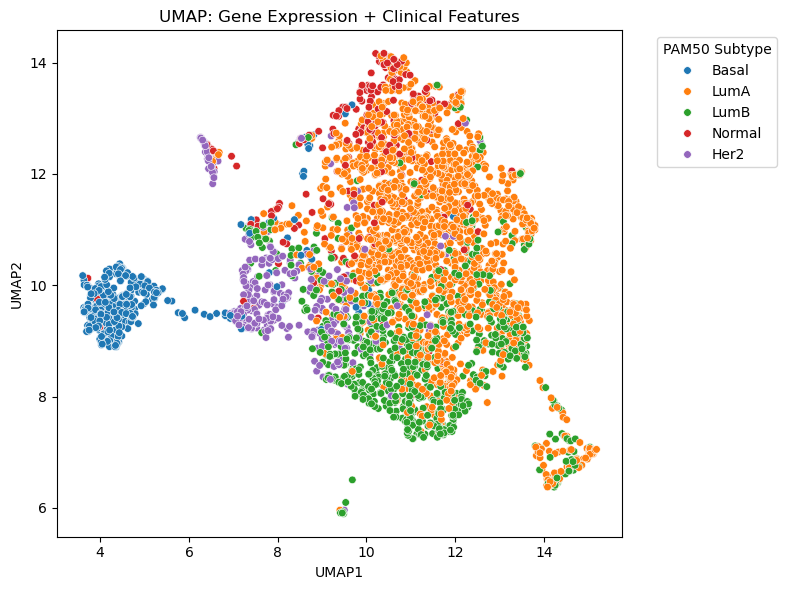

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import umap
import matplotlib.pyplot as plt
import seaborn as sns


id_columns = [
    'last_update_date__Mar 12 2018',
    'last_update_date__May 04 2022',
    'instrument model__HiSeq 2000',
    'instrument model__NextSeq 500',
    "er prediction mgc", "pgr prediction mgc", "her2 prediction mgc", "ki67 prediction mgc",
    "nhg prediction mgc", "er prediction sgc", "pgr prediction sgc", "her2 prediction sgc", "ki67 prediction sgc"
]

# Keep numeric clinical columns only
clinical_features = clinical_df_indexed.select_dtypes(include=[np.number]).drop(columns=[col for col in id_columns if col in clinical_df_indexed.columns])

# Align sample indices
clinical_features = clinical_features.loc[zscored_df.index]

# --- Step 1: Separate column types ---
onehot_cols = [col for col in clinical_features.columns if set(clinical_features[col].dropna().unique()) <= {0, 1}]
numeric_cols = [col for col in clinical_features.columns if col not in onehot_cols]

# --- Step 2: Impute missing values ---
imp_num = SimpleImputer(strategy="mean")
imp_bin = SimpleImputer(strategy="constant", fill_value=0)

clinical_numeric = pd.DataFrame(imp_num.fit_transform(clinical_features[numeric_cols]), 
                                columns=numeric_cols, index=clinical_features.index)

clinical_onehot = pd.DataFrame(imp_bin.fit_transform(clinical_features[onehot_cols]), 
                               columns=onehot_cols, index=clinical_features.index)

clinical_imputed = pd.concat([clinical_numeric, clinical_onehot], axis=1)

# --- Step 3: Reduce gene expression with PCA ---
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(zscored_df_subset)


# --- Step 4: Scale clinical features ---
scaler = StandardScaler()
clinical_scaled = scaler.fit_transform(clinical_imputed)

# --- Step 5: Combine expression + clinical ---
X_combined = np.hstack((X_pca, clinical_scaled))

# --- Step 6: UMAP projection ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_combined)

# --- Step 7: Create DataFrame for downstream use ---
umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=zscored_df.index)
umap_df = umap_df.join(clinical_df_indexed)

# Reconstruct pam50_subtype from one-hot columns
subtype_cols = [col for col in umap_df.columns if col.startswith("pam50 subtype__")]

# Convert one-hot back to a single column
umap_df["pam50_subtype"] = umap_df[subtype_cols].idxmax(axis=1).str.replace("pam50 subtype__", "")


# --- Step 8: Visualize ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP: Gene Expression + Clinical Features")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score

# --- KMeans clustering ---
kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(umap_df[["UMAP1", "UMAP2"]])

# --- Evaluation subset: must have true labels (for ARI) ---
umap_eval = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

# --- Adjusted Rand Index ---
ari = adjusted_rand_score(umap_eval["pam50_subtype"], umap_eval["Cluster"])

# --- Silhouette Score (on all points, unsupervised) ---
sil = silhouette_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

# --- Additional metrics ---
ch_score = calinski_harabasz_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
db_score = davies_bouldin_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

# --- Print all metrics ---
print(f"Adjusted Rand Index (vs PAM50): {ari:.3f}")
print(f"Silhouette Score:               {sil:.3f}")
print(f"Calinski-Harabasz Index:        {ch_score:.2f}")
print(f"Davies-Bouldin Index:           {db_score:.2f}")


Adjusted Rand Index (vs PAM50): 0.250
Silhouette Score:               0.412
Calinski-Harabasz Index:        3678.52
Davies-Bouldin Index:           0.80


These metrics are very similar to the full df ones, that way I can likely subset to the most variable 5000 genes without losing too much information.

# DB
ttried replicating the results from above from the SQLite DB - realised it was too slow. Going for a different approach.

In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("/Users/sarah/Code/bioinformatics-tool/backend/data.sqlite3")

# Expression: median-centered (if you want)
expression_median = pd.read_sql("SELECT * FROM expression_median", conn)
df = expression_median.pivot(index='sample_id', columns='gene', values='value')

# Z-scored
expression_zscored = pd.read_sql("SELECT * FROM expression_zscored", conn)
zscored_df = expression_zscored.pivot(index='sample_id', columns='gene', values='value')

# Clinical metadata
clinical_df = pd.read_sql("SELECT * FROM clinical_metadata", conn).set_index("sample_id")

conn.close()


In [ ]:
clinical_df_indexed = clinical_df.copy()

# Align both
common_samples = df.index.intersection(clinical_df_indexed.index)
expression_df = df.loc[common_samples]
clinical_df_indexed = clinical_df_indexed.loc[common_samples]

# Parquet
Different approach since sqlite3 was too slow.

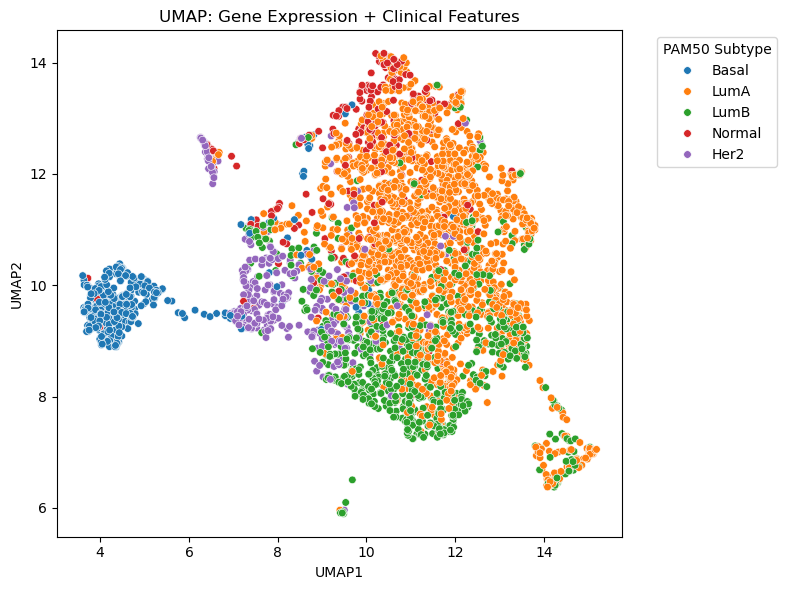

Adjusted Rand Index (vs PAM50): 0.250
Silhouette Score:               0.412
Calinski-Harabasz Index:        3678.52
Davies-Bouldin Index:           0.80


In [8]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv

# --- Load environment variables for file paths ---
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

# Paths (change as needed or keep env system)
EXPRESSION_PARQUET ="/Users/sarah/Code/bioinformatics-tool/backend/zscored_top5000.parquet"  # Add this variable to your .env file!
CLINICAL_CSV = os.getenv("CLINICAL")

# --- 1. Load Data ---
expression_df = pd.read_parquet(EXPRESSION_PARQUET)   # genes as columns, samples as rows
clinical_df = pd.read_csv(CLINICAL_CSV, index_col=0)  # samples as rows, clinical features as columns

# --- 2. Align samples between dataframes ---
common_samples = expression_df.index.intersection(clinical_df.index)
expression_df = expression_df.loc[common_samples]
clinical_df = clinical_df.loc[common_samples]

# --- 3. Z-score normalize gene expression (across samples for each gene) ---
from sklearn.preprocessing import StandardScaler

zscored_expr = pd.DataFrame(
    StandardScaler().fit_transform(expression_df),
    index=expression_df.index,
    columns=expression_df.columns
)

# --- 4. Select & process clinical features ---
id_columns = [
    'last_update_date__Mar 12 2018',
    'last_update_date__May 04 2022',
    'instrument model__HiSeq 2000',
    'instrument model__NextSeq 500',
    "er prediction mgc", "pgr prediction mgc", "her2 prediction mgc", "ki67 prediction mgc",
    "nhg prediction mgc", "er prediction sgc", "pgr prediction sgc", "her2 prediction sgc", "ki67 prediction sgc"
]

clinical_features = clinical_df.select_dtypes(include=[np.number]).drop(
    columns=[col for col in id_columns if col in clinical_df.columns],
    errors='ignore'
)
clinical_features = clinical_features.loc[zscored_expr.index]

onehot_cols = [col for col in clinical_features.columns if set(clinical_features[col].dropna().unique()) <= {0, 1}]
numeric_cols = [col for col in clinical_features.columns if col not in onehot_cols]

from sklearn.impute import SimpleImputer

imp_num = SimpleImputer(strategy="mean")
imp_bin = SimpleImputer(strategy="constant", fill_value=0)

clinical_numeric = pd.DataFrame(
    imp_num.fit_transform(clinical_features[numeric_cols]), 
    columns=numeric_cols, 
    index=clinical_features.index
)
clinical_onehot = pd.DataFrame(
    imp_bin.fit_transform(clinical_features[onehot_cols]), 
    columns=onehot_cols, 
    index=clinical_features.index
)

clinical_imputed = pd.concat([clinical_numeric, clinical_onehot], axis=1)

# --- 5. PCA on gene expression (e.g., 100 PCs) ---
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(zscored_expr)

# --- 6. Scale clinical features ---
clinical_scaled = StandardScaler().fit_transform(clinical_imputed)

# --- 7. Concatenate for joint analysis ---
X_combined = np.hstack([X_pca, clinical_scaled])

# --- 8. UMAP projection ---
import umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_combined)

umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=zscored_expr.index)
umap_df = umap_df.join(clinical_df)

# --- 9. Recover PAM50 subtype if one-hot encoded ---
subtype_cols = [col for col in umap_df.columns if col.startswith("pam50 subtype__")]
if subtype_cols:
    umap_df["pam50_subtype"] = (
        umap_df[subtype_cols].idxmax(axis=1).str.replace("pam50 subtype__", "")
    )

# --- 10. Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP: Gene Expression + Clinical Features")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 11. KMeans clustering and evaluation ---
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score

kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(umap_df[["UMAP1", "UMAP2"]])

# Only evaluate where true subtype is present
umap_eval = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

ari = adjusted_rand_score(umap_eval["pam50_subtype"], umap_eval["Cluster"])
sil = silhouette_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
ch_score = calinski_harabasz_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
db_score = davies_bouldin_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

print(f"Adjusted Rand Index (vs PAM50): {ari:.3f}")
print(f"Silhouette Score:               {sil:.3f}")
print(f"Calinski-Harabasz Index:        {ch_score:.2f}")
print(f"Davies-Bouldin Index:           {db_score:.2f}")


## Same Pipeline with KNN

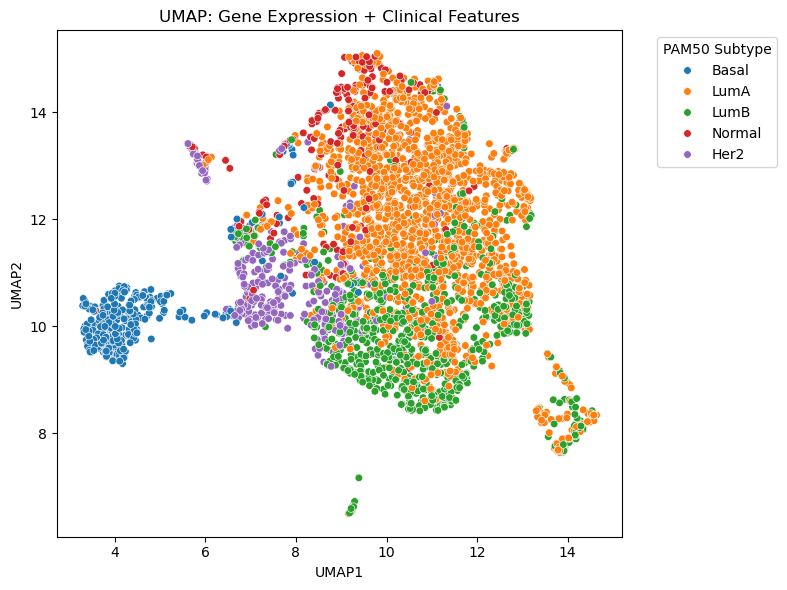

Adjusted Rand Index (vs PAM50): 0.254
Silhouette Score:               0.412
Calinski-Harabasz Index:        3538.99
Davies-Bouldin Index:           0.80


In [9]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from sklearn.impute import KNNImputer

# --- Load environment variables for file paths ---
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

# Paths (change as needed or keep env system)
EXPRESSION_PARQUET ="/Users/sarah/Code/bioinformatics-tool/backend/zscored_top5000.parquet"  # Add this variable to your .env file!
CLINICAL_CSV = os.getenv("CLINICAL")

# --- 1. Load Data ---
expression_df = pd.read_parquet(EXPRESSION_PARQUET)   # genes as columns, samples as rows
clinical_df = pd.read_csv(CLINICAL_CSV, index_col=0)  # samples as rows, clinical features as columns

# --- 2. Align samples between dataframes ---
common_samples = expression_df.index.intersection(clinical_df.index)
expression_df = expression_df.loc[common_samples]
clinical_df = clinical_df.loc[common_samples]

# --- 3. Z-score normalize gene expression (across samples for each gene) ---
from sklearn.preprocessing import StandardScaler

zscored_expr = pd.DataFrame(
    StandardScaler().fit_transform(expression_df),
    index=expression_df.index,
    columns=expression_df.columns
)

# --- 4. Select & process clinical features ---
id_columns = [
    'last_update_date__Mar 12 2018',
    'last_update_date__May 04 2022',
    'instrument model__HiSeq 2000',
    'instrument model__NextSeq 500',
    "er prediction mgc", "pgr prediction mgc", "her2 prediction mgc", "ki67 prediction mgc",
    "nhg prediction mgc", "er prediction sgc", "pgr prediction sgc", "her2 prediction sgc", "ki67 prediction sgc"
]

clinical_features = clinical_df.select_dtypes(include=[np.number]).drop(
    columns=[col for col in id_columns if col in clinical_df.columns],
    errors='ignore'
)
clinical_features = clinical_features.loc[zscored_expr.index]

onehot_cols = [col for col in clinical_features.columns if set(clinical_features[col].dropna().unique()) <= {0, 1}]
numeric_cols = [col for col in clinical_features.columns if col not in onehot_cols]

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights="distance")
clinical_imputed = pd.DataFrame(
    imputer.fit_transform(clinical_features),
    columns=clinical_features.columns,
    index=clinical_features.index
)


# --- 5. PCA on gene expression (e.g., 100 PCs) ---
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(zscored_expr)

# --- 6. Scale clinical features ---
clinical_scaled = StandardScaler().fit_transform(clinical_imputed)

# --- 7. Concatenate for joint analysis ---
X_combined = np.hstack([X_pca, clinical_scaled])

# --- 8. UMAP projection ---
import umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_combined)

umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=zscored_expr.index)
umap_df = umap_df.join(clinical_df)

# --- 9. Recover PAM50 subtype if one-hot encoded ---
subtype_cols = [col for col in umap_df.columns if col.startswith("pam50 subtype__")]
if subtype_cols:
    umap_df["pam50_subtype"] = (
        umap_df[subtype_cols].idxmax(axis=1).str.replace("pam50 subtype__", "")
    )

# --- 10. Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP: Gene Expression + Clinical Features")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 11. KMeans clustering and evaluation ---
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score

kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(umap_df[["UMAP1", "UMAP2"]])

# Only evaluate where true subtype is present
umap_eval = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

ari = adjusted_rand_score(umap_eval["pam50_subtype"], umap_eval["Cluster"])
sil = silhouette_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
ch_score = calinski_harabasz_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
db_score = davies_bouldin_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

print(f"Adjusted Rand Index (vs PAM50): {ari:.3f}")
print(f"Silhouette Score:               {sil:.3f}")
print(f"Calinski-Harabasz Index:        {ch_score:.2f}")
print(f"Davies-Bouldin Index:           {db_score:.2f}")


# With Filtered Df 

Loading clinical data from: /Users/sarah/Code/bioinformatics-tool/backend/data/GSE96058_clinical_quality_checked.csv


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


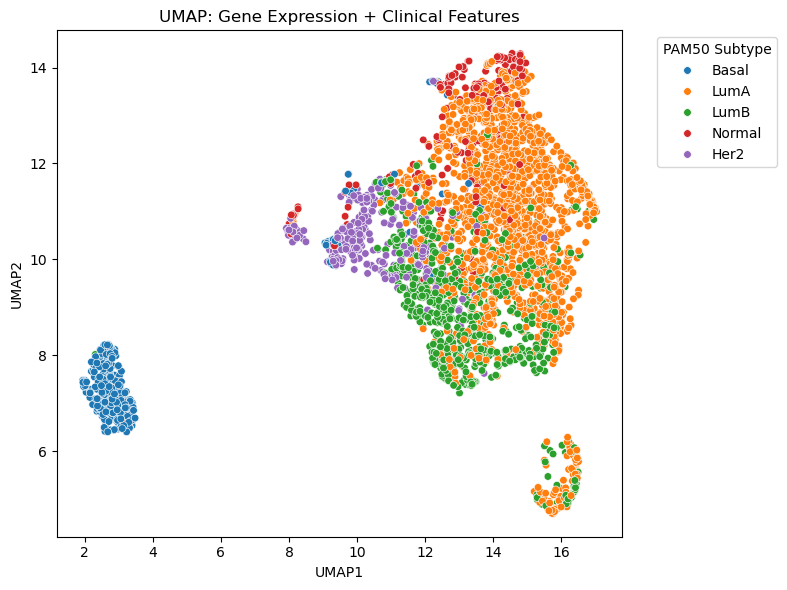

Adjusted Rand Index (vs PAM50): 0.290
Silhouette Score:               0.479
Calinski-Harabasz Index:        6687.77
Davies-Bouldin Index:           0.62


In [29]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv

# --- Load environment variables for file paths ---
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

# Usage in a notebook
repo_root = find_repo_root()


# Paths (change as needed or keep env system)
EXPRESSION_PARQUET ="/Users/sarah/Code/bioinformatics-tool/backend/data/parquet/filtered_top5000.parquet"  # Add this variable to your .env file!
CLINICAL_CSV = repo_root / os.getenv("CLINICAL_QUALITY_CHECKED")
#CLINICAL_CSV = repo_root / os.getenv("CLINICAL")

print(f"Loading clinical data from: {CLINICAL_CSV}"
      )
clinical_df = pd.read_csv(CLINICAL_CSV, index_col=0)

# CLINICAL_CSV = os.getenv("CLINICAL")

# --- 1. Load Data ---
expression_df = pd.read_parquet(EXPRESSION_PARQUET)   # genes as columns, samples as rows
clinical_df = pd.read_csv(CLINICAL_CSV, index_col=0)  # samples as rows, clinical features as columns

# --- 2. Align samples between dataframes ---
common_samples = expression_df.index.intersection(clinical_df.index)
expression_df = expression_df.loc[common_samples]
clinical_df = clinical_df.loc[common_samples]

# --- 3. Z-score normalize gene expression (across samples for each gene) ---
from sklearn.preprocessing import StandardScaler

zscored_expr = pd.DataFrame(
    StandardScaler().fit_transform(expression_df),
    index=expression_df.index,
    columns=expression_df.columns
)

# --- 4. Select & process clinical features ---
id_columns = [
    'last_update_date__Mar 12 2018',
    'last_update_date__May 04 2022',
    'instrument model__HiSeq 2000',
    'instrument model__NextSeq 500',
    "er prediction mgc", "pgr prediction mgc", "her2 prediction mgc", "ki67 prediction mgc",
    "nhg prediction mgc", "er prediction sgc", "pgr prediction sgc", "her2 prediction sgc", "ki67 prediction sgc"
]

clinical_features = clinical_df.select_dtypes(include=[np.number]).drop(
    columns=[col for col in id_columns if col in clinical_df.columns],
    errors='ignore'
)
clinical_features = clinical_features.loc[zscored_expr.index]

onehot_cols = [col for col in clinical_features.columns if set(clinical_features[col].dropna().unique()) <= {0, 1}]
numeric_cols = [col for col in clinical_features.columns if col not in onehot_cols]

from sklearn.impute import SimpleImputer

imp_num = SimpleImputer(strategy="mean")
imp_bin = SimpleImputer(strategy="constant", fill_value=0)

clinical_numeric = pd.DataFrame(
    imp_num.fit_transform(clinical_features[numeric_cols]), 
    columns=numeric_cols, 
    index=clinical_features.index
)
clinical_onehot = pd.DataFrame(
    imp_bin.fit_transform(clinical_features[onehot_cols]), 
    columns=onehot_cols, 
    index=clinical_features.index
)

clinical_imputed = pd.concat([clinical_numeric, clinical_onehot], axis=1)

# --- 5. PCA on gene expression (e.g., 100 PCs) ---
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(zscored_expr)

# --- 6. Scale clinical features ---
clinical_scaled = StandardScaler().fit_transform(clinical_imputed)

# --- 7. Concatenate for joint analysis ---
X_combined = np.hstack([X_pca, clinical_scaled])

# --- 8. UMAP projection ---
import umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_combined)

umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=zscored_expr.index)
umap_df = umap_df.join(clinical_df)

# --- 9. Recover PAM50 subtype if one-hot encoded ---
subtype_cols = [col for col in umap_df.columns if col.startswith("pam50 subtype__")]
if subtype_cols:
    umap_df["pam50_subtype"] = (
        umap_df[subtype_cols].idxmax(axis=1).str.replace("pam50 subtype__", "")
    )

# --- 10. Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP: Gene Expression + Clinical Features")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 11. KMeans clustering and evaluation ---
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score

kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(umap_df[["UMAP1", "UMAP2"]])

# Only evaluate where true subtype is present
umap_eval = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

ari = adjusted_rand_score(umap_eval["pam50_subtype"], umap_eval["Cluster"])
sil = silhouette_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
ch_score = calinski_harabasz_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
db_score = davies_bouldin_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

print(f"Adjusted Rand Index (vs PAM50): {ari:.3f}")
print(f"Silhouette Score:               {sil:.3f}")
print(f"Calinski-Harabasz Index:        {ch_score:.2f}")
print(f"Davies-Bouldin Index:           {db_score:.2f}")


In [14]:

CLINICAL_CSV = repo_root / os.getenv("CLINICAL_QUALITY_CHECKED")

print(f"Loading clinical data from: {CLINICAL_CSV}"
      )
clinical_df = pd.read_csv(CLINICAL_CSV, index_col=0)

Loading clinical data from: /Users/sarah/Code/bioinformatics-tool/backend/data/GSE96058_clinical_quality_checked.csv


In [15]:
print(expression_df.index[:5])
print(clinical_df.index[:5])


Index([], dtype='object')
Index(['F1', 'F2', 'F3', 'F4', 'F5'], dtype='object')


In [18]:
expression_df.shape

(3189, 26151)

In [19]:
clinical_df.shape

(3189, 32)

/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


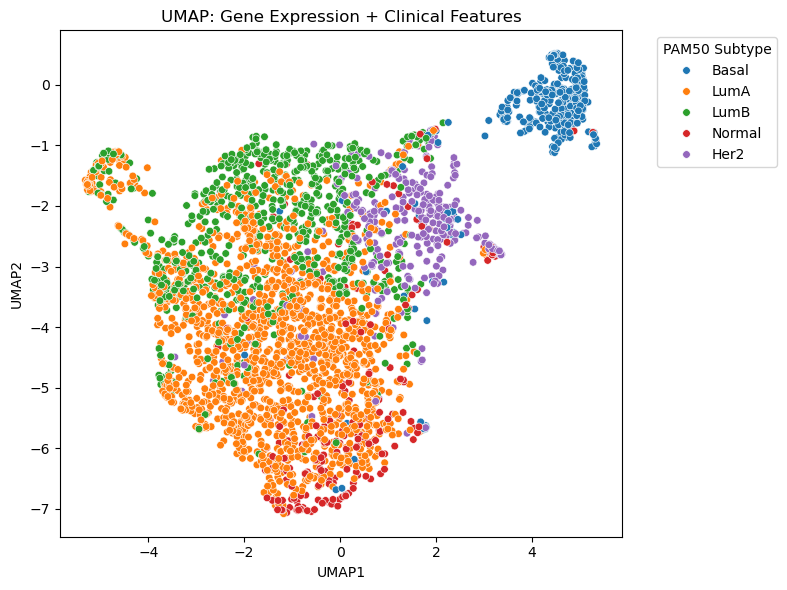

Adjusted Rand Index (vs PAM50): 0.211
Silhouette Score:               0.395
Calinski-Harabasz Index:        3761.31
Davies-Bouldin Index:           0.82


In [25]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from pathlib import Path

# --- Load environment variables for file paths ---
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

# Usage in a notebook
repo_root = find_repo_root()

expression_path = repo_root / os.getenv ("QUALITY_CHECKED")# Add this variable to your .env file!
CLINICAL_CSV = repo_root / os.getenv("CLINICAL")

# --- 1. Load Data ---
expression_df = pd.read_csv(expression_path, index_col=0)   # genes as columns, samples as rows
clinical_df = pd.read_csv(CLINICAL_CSV, index_col=0)  # samples as rows, clinical features as columns

# --- 2. Align samples between dataframes ---
common_samples = expression_df.index.intersection(clinical_df.index)
expression_df = expression_df.loc[common_samples]
clinical_df = clinical_df.loc[common_samples]

# --- 3. Z-score normalize gene expression (across samples for each gene) ---
from sklearn.preprocessing import StandardScaler

zscored_expr = pd.DataFrame(
    StandardScaler().fit_transform(expression_df),
    index=expression_df.index,
    columns=expression_df.columns
)

# --- 4. Select & process clinical features ---
id_columns = [
    'last_update_date__Mar 12 2018',
    'last_update_date__May 04 2022',
    'instrument model__HiSeq 2000',
    'instrument model__NextSeq 500',
    "er prediction mgc", "pgr prediction mgc", "her2 prediction mgc", "ki67 prediction mgc",
    "nhg prediction mgc", "er prediction sgc", "pgr prediction sgc", "her2 prediction sgc", "ki67 prediction sgc"
]

clinical_features = clinical_df.select_dtypes(include=[np.number]).drop(
    columns=[col for col in id_columns if col in clinical_df.columns],
    errors='ignore'
)
clinical_features = clinical_features.loc[zscored_expr.index]

onehot_cols = [col for col in clinical_features.columns if set(clinical_features[col].dropna().unique()) <= {0, 1}]
numeric_cols = [col for col in clinical_features.columns if col not in onehot_cols]

from sklearn.impute import SimpleImputer

imp_num = SimpleImputer(strategy="mean")
imp_bin = SimpleImputer(strategy="constant", fill_value=0)

clinical_numeric = pd.DataFrame(
    imp_num.fit_transform(clinical_features[numeric_cols]), 
    columns=numeric_cols, 
    index=clinical_features.index
)
clinical_onehot = pd.DataFrame(
    imp_bin.fit_transform(clinical_features[onehot_cols]), 
    columns=onehot_cols, 
    index=clinical_features.index
)

clinical_imputed = pd.concat([clinical_numeric, clinical_onehot], axis=1)

# --- 5. PCA on gene expression (e.g., 100 PCs) ---
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(zscored_expr)

# --- 6. Scale clinical features ---
clinical_scaled = StandardScaler().fit_transform(clinical_imputed)

# --- 7. Concatenate for joint analysis ---
X_combined = np.hstack([X_pca, clinical_scaled])

# --- 8. UMAP projection ---
import umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_combined)

umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=zscored_expr.index)
umap_df = umap_df.join(clinical_df)

# --- 9. Recover PAM50 subtype if one-hot encoded ---
subtype_cols = [col for col in umap_df.columns if col.startswith("pam50 subtype__")]
if subtype_cols:
    umap_df["pam50_subtype"] = (
        umap_df[subtype_cols].idxmax(axis=1).str.replace("pam50 subtype__", "")
    )

# --- 10. Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP: Gene Expression + Clinical Features")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 11. KMeans clustering and evaluation ---
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score

kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(umap_df[["UMAP1", "UMAP2"]])

# Only evaluate where true subtype is present
umap_eval = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

ari = adjusted_rand_score(umap_eval["pam50_subtype"], umap_eval["Cluster"])
sil = silhouette_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
ch_score = calinski_harabasz_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
db_score = davies_bouldin_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

print(f"Adjusted Rand Index (vs PAM50): {ari:.3f}")
print(f"Silhouette Score:               {sil:.3f}")
print(f"Calinski-Harabasz Index:        {ch_score:.2f}")
print(f"Davies-Bouldin Index:           {db_score:.2f}")


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


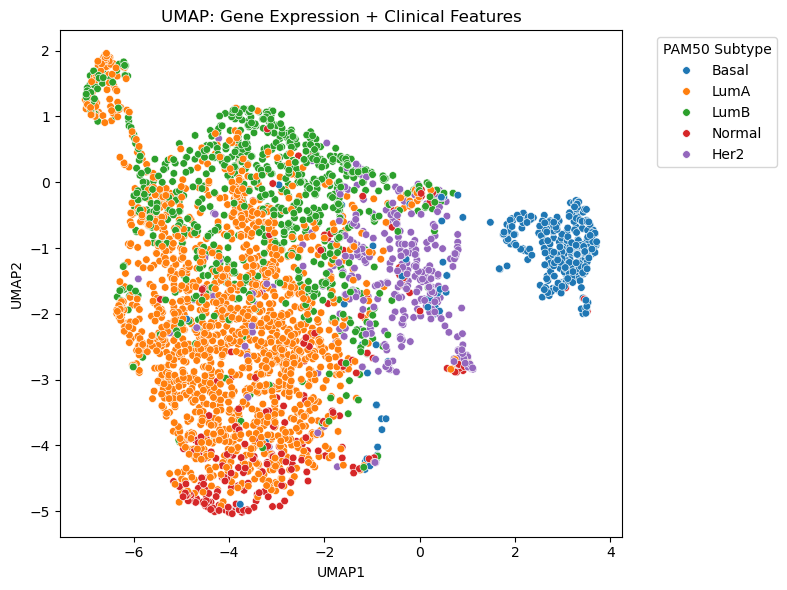

Adjusted Rand Index (vs PAM50): 0.258
Silhouette Score:               0.410
Calinski-Harabasz Index:        3911.03
Davies-Bouldin Index:           0.78


In [24]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from pathlib import Path

# --- Load environment variables for file paths ---
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

# Usage in a notebook
repo_root = find_repo_root()

expression_path = repo_root / os.getenv ("FILTERED")# Add this variable to your .env file!
CLINICAL_CSV = repo_root / os.getenv("CLINICAL")

# --- 1. Load Data ---
expression_df = pd.read_csv(expression_path, index_col=0)   # genes as columns, samples as rows
clinical_df = pd.read_csv(CLINICAL_CSV, index_col=0)  # samples as rows, clinical features as columns

# --- 2. Align samples between dataframes ---
common_samples = expression_df.index.intersection(clinical_df.index)
expression_df = expression_df.loc[common_samples]
clinical_df = clinical_df.loc[common_samples]

# --- 3. Z-score normalize gene expression (across samples for each gene) ---
from sklearn.preprocessing import StandardScaler

zscored_expr = pd.DataFrame(
    StandardScaler().fit_transform(expression_df),
    index=expression_df.index,
    columns=expression_df.columns
)

# --- 4. Select & process clinical features ---
id_columns = [
    'last_update_date__Mar 12 2018',
    'last_update_date__May 04 2022',
    'instrument model__HiSeq 2000',
    'instrument model__NextSeq 500',
    "er prediction mgc", "pgr prediction mgc", "her2 prediction mgc", "ki67 prediction mgc",
    "nhg prediction mgc", "er prediction sgc", "pgr prediction sgc", "her2 prediction sgc", "ki67 prediction sgc"
]

clinical_features = clinical_df.select_dtypes(include=[np.number]).drop(
    columns=[col for col in id_columns if col in clinical_df.columns],
    errors='ignore'
)
clinical_features = clinical_features.loc[zscored_expr.index]

onehot_cols = [col for col in clinical_features.columns if set(clinical_features[col].dropna().unique()) <= {0, 1}]
numeric_cols = [col for col in clinical_features.columns if col not in onehot_cols]

from sklearn.impute import SimpleImputer

imp_num = SimpleImputer(strategy="mean")
imp_bin = SimpleImputer(strategy="constant", fill_value=0)

clinical_numeric = pd.DataFrame(
    imp_num.fit_transform(clinical_features[numeric_cols]), 
    columns=numeric_cols, 
    index=clinical_features.index
)
clinical_onehot = pd.DataFrame(
    imp_bin.fit_transform(clinical_features[onehot_cols]), 
    columns=onehot_cols, 
    index=clinical_features.index
)

clinical_imputed = pd.concat([clinical_numeric, clinical_onehot], axis=1)

# --- 5. PCA on gene expression (e.g., 100 PCs) ---
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(zscored_expr)

# --- 6. Scale clinical features ---
clinical_scaled = StandardScaler().fit_transform(clinical_imputed)

# --- 7. Concatenate for joint analysis ---
X_combined = np.hstack([X_pca, clinical_scaled])

# --- 8. UMAP projection ---
import umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_combined)

umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=zscored_expr.index)
umap_df = umap_df.join(clinical_df)

# --- 9. Recover PAM50 subtype if one-hot encoded ---
subtype_cols = [col for col in umap_df.columns if col.startswith("pam50 subtype__")]
if subtype_cols:
    umap_df["pam50_subtype"] = (
        umap_df[subtype_cols].idxmax(axis=1).str.replace("pam50 subtype__", "")
    )

# --- 10. Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP: Gene Expression + Clinical Features")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 11. KMeans clustering and evaluation ---
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score

kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(umap_df[["UMAP1", "UMAP2"]])

# Only evaluate where true subtype is present
umap_eval = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

ari = adjusted_rand_score(umap_eval["pam50_subtype"], umap_eval["Cluster"])
sil = silhouette_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
ch_score = calinski_harabasz_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
db_score = davies_bouldin_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

print(f"Adjusted Rand Index (vs PAM50): {ari:.3f}")
print(f"Silhouette Score:               {sil:.3f}")
print(f"Calinski-Harabasz Index:        {ch_score:.2f}")
print(f"Davies-Bouldin Index:           {db_score:.2f}")
